# Planning a Ligand Network with Lomap

A [Ligand Network] is a graph of transformations between small molecules, typically such that every small molecule can reach every other small molecule via a series of transformations. This eventually forms the graph of the free energy campaign. A `LigandNetwork` can be generated from a collection of `SmallMoleculeComponent` instances by optimising over possible networks according to some criteria; in OpenFE, this involves combining a network generating strategy with a scoring function for individual mappings.
In this cookbook we are generating a network using the network generator provided in [LOMAP].

[Ligand Network]: https://docs.openfree.energy/en/stable/reference/api/generated/openfe.setup.LigandNetwork.html
[LOMAP]: https://github.com/OpenFreeEnergy/Lomap/tree/main

## Setup

In [1]:
%matplotlib inline

from rdkit import Chem
from openmm import unit

import openfe

This cookbook assumes you've already loaded a collection of `SmallMoleculeComponent` objects into an iterable called `ligands`. For more information, see [Loading Small Molecules]:

[Loading Small Molecules]: https://docs.openfree.energy/en/stable/cookbook/loading_molecules.html#loading-small-molecules

In [2]:
ligands = [
    openfe.SmallMoleculeComponent(mol) 
    for mol in Chem.SDMolSupplier(
        "assets/somebenzenes.sdf", 
        removeHs=False,
    )
]

## Choose an atom mapper

An atom mapper produces mappings between two given ligands. Atom mapper classes inherit from [LigandAtomMapper]. Each atom mapper suggests one or more mappings, which can be scored seperately. As a result, multiple atom mappers can be used to generate additional mappings for network planning.

[LigandAtomMapper]: https://docs.openfree.energy/en/stable/reference/api/generated/openfe.setup.atom_mapping.LigandAtomMapper.html

In [3]:
mappers = [
    openfe.setup.LomapAtomMapper(
        time=20, # Time out if MCS algorithm takes 20 seconds
        threed=True, # Use atom positions to prune symmetric mappings
        max3d=1.0, # Forbid mapping between atoms more than 1.0 Å apart
        element_change=True, # Allow mappings that change an atoms element
        seed='', # Empty SMARTS string causes MCS search to start from scratch
        shift=False, # Keep pre-aligned atom positions for 3D position checks
    ),
    # openfe.setup.PersesAtomMapper(
    #     allow_ring_breaking=True, # Propose mappings that break cyclic systems
    #     preserve_chirality=True, # Forbid mappings that change stereochemistry
    #     use_positions=True, # Use atom positions rather than MCS to choose mappings
    #     coordinate_tolerance=0.25 * unit.angstrom, # Forbid mappings between distant atoms
    # ),
]

This approach of interchangeable mappers is possible as they all provide a common `.suggest_mappings` method,
which in turn creates a common `LigandAtomMapping` object,
allowing tooling to mix and match which mapper they use.

In [4]:
?mappers[0].suggest_mappings

Signature:
mappers[0].suggest_mappings(
    componentA: gufe.components.smallmoleculecomponent.SmallMoleculeComponent,
    componentB: gufe.components.smallmoleculecomponent.SmallMoleculeComponent,
) -> Iterable[gufe.mapping.ligandatommapping.LigandAtomMapping]
Docstring:
Generate one or more mappings between two small molecules

Parameters
----------
componentA, componentB: gufe.SmallMoleculeComponent

Returns
-------
mapping : Iterable[LigandAtomMapping]
  potential mappings
File:      ~/miniconda3/envs/openfe_dev/lib/python3.11/site-packages/lomap/gufe_bindings/mapper.py
Type:      method

## Choose a scoring function

Many ligand network planners require some way to score each possible network so that the optimal network can be identified. OpenFE scores networks by the quality of the mappings between ligands - transformations that are expected to converge quickly without introducing artifacts are scored highly, and more drastic or risky alchemy is penalised. A scoring function is a function that takes an atom mapping and returns a float between 0.0 and 1.0, with higher numbers representing better maps.

In [5]:
# The product of other LOMAP scorers
scorer = openfe.lomap_scorers.default_lomap_score 

# # The default PERSES scoring function
# scorer = openfe.perses_scorers.default_perses_score 

# # Or define your own scoring function
# scorer = lambda m: (
#     openfe.lomap_scorers.default_lomap_score(m) 
#     * openfe.perses_scorers.default_perses_scorer(m)
# )

## Plan the network

Finally, pass the ligands, mapper and scorer to a planner to generate the LOMAP network. A planner takes these three arguments (and perhaps some more) and returns a `LigandNetwork`. The LOMAP network provides edge redundancy for troubleshooting:

In [6]:
# Choose the LOMAP network that adds some closed ligand cycles
ligand_network = openfe.ligand_network_planning.generate_lomap_network(
    molecules=ligands,
    mappers=mappers,
    scorer=scorer,
)

INFO:	Trying to remove edge 4-5 with similarity 0.670320
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 4-5
INFO:	Trying to remove edge 3-4 with similarity 0.670320
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 3-4
INFO:	Trying to remove edge 3-5 with similarity 0.704688
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 3-5
INFO:	Trying to remove edge 3-6 with similarity 0.704688
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 3-6
INFO:	Trying to remove edge 4-6 with similarity 0.704688
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 4-6
INFO:	Trying to remove edge 2-3 with similarity 0.740818
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 2-3
INFO:	Trying to remove edge 2-5 with similarity 0.740818
INFO:	Checking edge deletion on distance-to-actives 0 vs 0
INFO:	Removed edge 2-5
INFO:	Trying to remove edge

## Visualize

For more ways to visualize a `LigandNetwork`, see [Visualizing Ligand Networks].

[Visualizing Ligand Networks]: https://docs.openfree.energy/en/stable/cookbook/ligandnetwork_vis.html

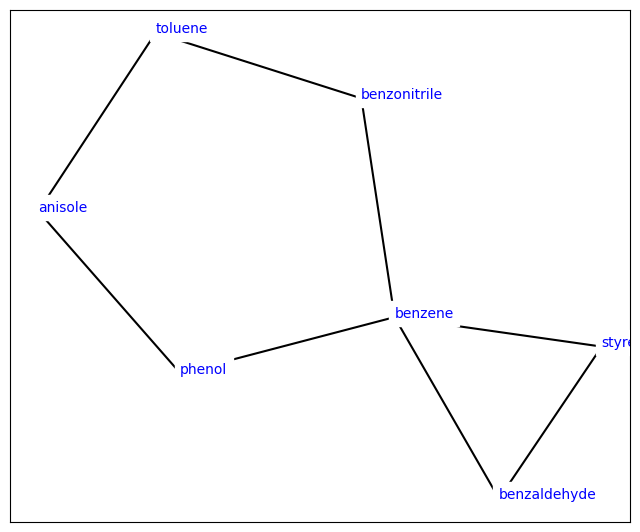

In [7]:
from openfe.utils.atommapping_network_plotting import plot_atommapping_network

plot_atommapping_network(ligand_network)

## What next

With a ligand network defined, a next logical step would be to choose and customise a free energy estimation method (in OpenFE parlance, a `Protocol`).  This is applied to edges of the network to estimate the free energy differences of traversing this network.